In [16]:
import dill
from wccm_support import np_interpolate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
results = []
with open("vpsc_results_12.pkl", "rb") as dill_file:
    results.extend(dill.load(dill_file))
with open("vpsc_results_23.pkl", "rb") as dill_file:
    results.extend(dill.load(dill_file))
with open("vpsc_results_13.pkl", "rb") as dill_file:
    results.extend(dill.load(dill_file))


Setting up the Matmodlab notebook environment


In [11]:
def align_pi_plane_with_axes_rot():
    """
    Returns a matrix that rotates the pi plane's normal to be the z axis
    i.e., a slice of pi plane becomes the xy plane after rotation
    """
    pi_vector = np.array([1, 1, 1]) / np.sqrt(3.)
    # wanted_vector = np.array([1, 0, 0])
    wanted_vector = np.array([0, 0, 1])
    wanted_vector = wanted_vector / np.linalg.norm(wanted_vector)
    added = (pi_vector + wanted_vector).reshape([-1, 1])
    # from Rodrigues' rotation formula, more info here: https://math.stackexchange.com/a/2672702
    rot_mat = 2 * (added @ added.T) / (added.T @ added) - np.eye(3)
    return rot_mat


def align_axes_with_pi_plane_rot():
    """
    Returns a matrix that undoes the align_pi_plane_with_axes_rot rotation
    """
    return np.linalg.inv(align_pi_plane_with_axes_rot())

align_axes_with_pi_plane_rot = align_axes_with_pi_plane_rot()
align_pi_plane_with_axes_rot = align_pi_plane_with_axes_rot()

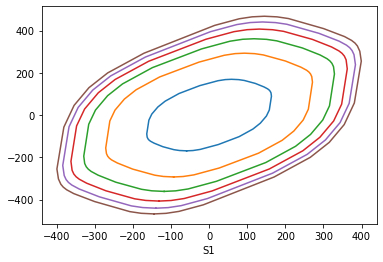

In [17]:
pcys_file = open(f'/Users/brian/Work/software/st-bingo/research/data/raw_data/YS_evo/75/PCYS.OUT', 'r')
sections = []
lines_in_file = None
for i, line in enumerate(pcys_file):
    if line.strip().startswith('S1'):
        sections.append(i)
    lines_in_file = i + 1 

pcys_file.close()
fig, axs = plt.subplots()

for i, sec in enumerate(sections):
    rows_to_read = range(sec, lines_in_file) if i == (len(sections) - 1) else range(sec, sections[i+1])
    #print(rows_to_read)

    vpsc_data = pd.read_csv(f'/Users/brian/Work/software/st-bingo/research/data/raw_data/YS_evo/75/PCYS.OUT', delim_whitespace=True, skiprows=lambda x: x not in rows_to_read)

    # Plot the vpsc output
    vpsc_data.plot(x='S1', y='S2', ax=axs, label=f'VPSC{i}', legend=False)



In [30]:

eqps_to_plot = np.array( [ 0.000000000000000000e+00, 2.500000000000000139e-02,
                           5.000000000000000278e-02, 7.499999999999999722e-02, 
                           1.000000000000000056e-01, 1.250000000000000000e-01 ] )
stress_points = [ [] for value in eqps_to_plot  ]
for setr in results:
    for mps in setr:
        stress_history = mps.df[['S.XX', 'S.YY', 'S.ZZ', 'REAL_EQPS']]
        stress_history = stress_history[stress_history['REAL_EQPS'] > 1e-6]
        SXX = np_interpolate(eqps_to_plot, stress_history, 'REAL_EQPS', 'S.XX')
        SYY = np_interpolate(eqps_to_plot, stress_history, 'REAL_EQPS', 'S.YY')
        SZZ = np_interpolate(eqps_to_plot, stress_history, 'REAL_EQPS', 'S.ZZ')
        #$print(eqps_to_plot, SXX, SYY, SZZ)
        for i, pnt in enumerate(eqps_to_plot):
            stress_points[i].append([SXX[i], SYY[i], SZZ[i]])
#print(stress_points)


pi_plane_points = [ [] for value in eqps_to_plot ]
for i, eqps in enumerate(eqps_to_plot):
    for stress_val in stress_points[i]:
        stress_pre = np.array(stress_val)[:3].T
        stress_val = stress_pre @ align_axes_with_pi_plane_rot
        pi_plane_points[i].append( list(stress_val[0:2]) )

print(pi_plane_points)
pi_plane_points = np.array(pi_plane_points)

[[[-157.3741826337718, -13.648113205573202], [-160.06651198695167, -23.647464630567494], [-174.27315411522954, -74.12210519842348], [-173.42472090177463, -85.76427992636626], [-171.68756470476117, -96.67017634241648], [-169.1696211742795, -106.71670128329916], [-166.01695488843674, -115.79734736538833], [-162.40705744330893, -123.83813583537247], [-158.52959470428667, -130.81683493099814], [-154.55116103924541, -136.78359083520778], [-150.56650944601407, -141.87636562102702], [-146.55255389860577, -146.3164184378293], [-142.3540571638855, -150.36826644737883], [-137.72077159146974, -154.26731992354726], [-132.38243490102374, -158.1471828297953], [-126.12166537185871, -162.00635548018758], [-118.81274343228309, -165.72718068985657], [-110.4234382430482, -169.12588059069145], [-100.99614791129218, -172.00358364927877], [-90.62391771618708, -174.181675072858], [-79.4287439269765, -175.51939201450477], [-67.54454843922052, -175.91800922122795], [-18.01067529217496, -160.13605449281306], [-

In [68]:
def draw_principal_axes(ax, length_of_axes=2.5, scale=100):
    """
    Draws principal axes on graph, change length of axes and scale
    """
    zero_pos = np.zeros(2)
    straight_up_pos = np.array([0, 1]) * length_of_axes
    bottom_right_pos = np.array([np.cos(-np.pi / 6.), np.sin(-np.pi / 6.)]) * length_of_axes
    bottom_left_pos = np.array([np.cos(7 * np.pi / 6.), np.sin(7 * np.pi / 6.)]) * length_of_axes

    ax.quiver(*zero_pos, *straight_up_pos, scale_units="xy", scale=1)
    ax.annotate(r"$\sigma_2$", straight_up_pos + np.array([0.25, -0.3]) * scale)

    ax.quiver(*zero_pos, *bottom_right_pos, scale_units="xy", scale=1)
    ax.annotate(r"$\sigma_1$", bottom_right_pos + np.array([-0.18, 0.45]) * scale)

    ax.quiver(*zero_pos, *bottom_left_pos, scale_units="xy", scale=1)
    # ax.annotate(r"$\sigma_3$", bottom_left_pos + np.array([0.1, -0.45]) * scale)
    ax.annotate(r"$\sigma_3$", bottom_left_pos + np.array([0.28, -0.4]) * scale)
    # ax.annotate(r"$\sigma_3$", bottom_left_pos + np.array([-0.18, -0.4]) * scale)

def plot_trajectory_of_transpose_pi(tdp, section):
    transposed_data = np.loadtxt(tdp)


    # find splits
    break_points = np.where(np.any(np.isnan(transposed_data), 1))[0].tolist()
    break_points.append(transposed_data.shape[0])

    start = 0
    X = transposed_data
    for i,end in enumerate(break_points):
        if i != section:
            start = end + 1
            continue
        else:
            dataframe = np.copy(X[start:end, :])
            break

    dataframe = pd.DataFrame(dataframe, columns=['S.XX', 'S.YY', 'S.ZZ', 'EQPS'])
    stresses_reference = np.array(dataframe[['S.XX', 'S.YY', 'S.ZZ']])
    pi_plane_reference = stresses_reference @ align_axes_with_pi_plane_rot

    f, ax = plt.subplots(figsize=(4, 4), dpi=300)
    ax.plot(pi_plane_reference[:,0], pi_plane_reference[:,1], 'k.--', label='Pure VM Model')
    # ax.plot(pi_stresses_GPSR[:,0], pi_stresses_GPSR[:,1], 'm.--', label='Stresses Real Space')
    # #ax.plot(pi_fict_stresses_GPSR[:,0], pi_fict_stresses_GPSR[:,1], 'r.--', label='Stresses Fictitious Space')
    ax.plot()
    scale_scale = np.max([np.max(pi_plane_reference[:,0]),  np.max(pi_plane_reference[:,1]) ])
    draw_principal_axes(ax, length_of_axes=420, scale=scale_scale/4)
    # # 
    ax.axis("equal")
    ax.set_ylim([-450, 450])
    ax.set_xlim([-450, 450])
    # c1 = plt.Circle( (0, 0 ),
    #                                     np.sqrt(2/3)*scale_scale ,
    #                                     fill = False )
    # ax.add_patch(c1)
    ax.set_xlabel("$S_1$ (MPa)")
    ax.set_ylabel("$S_2$ (MPa)")
    return ax


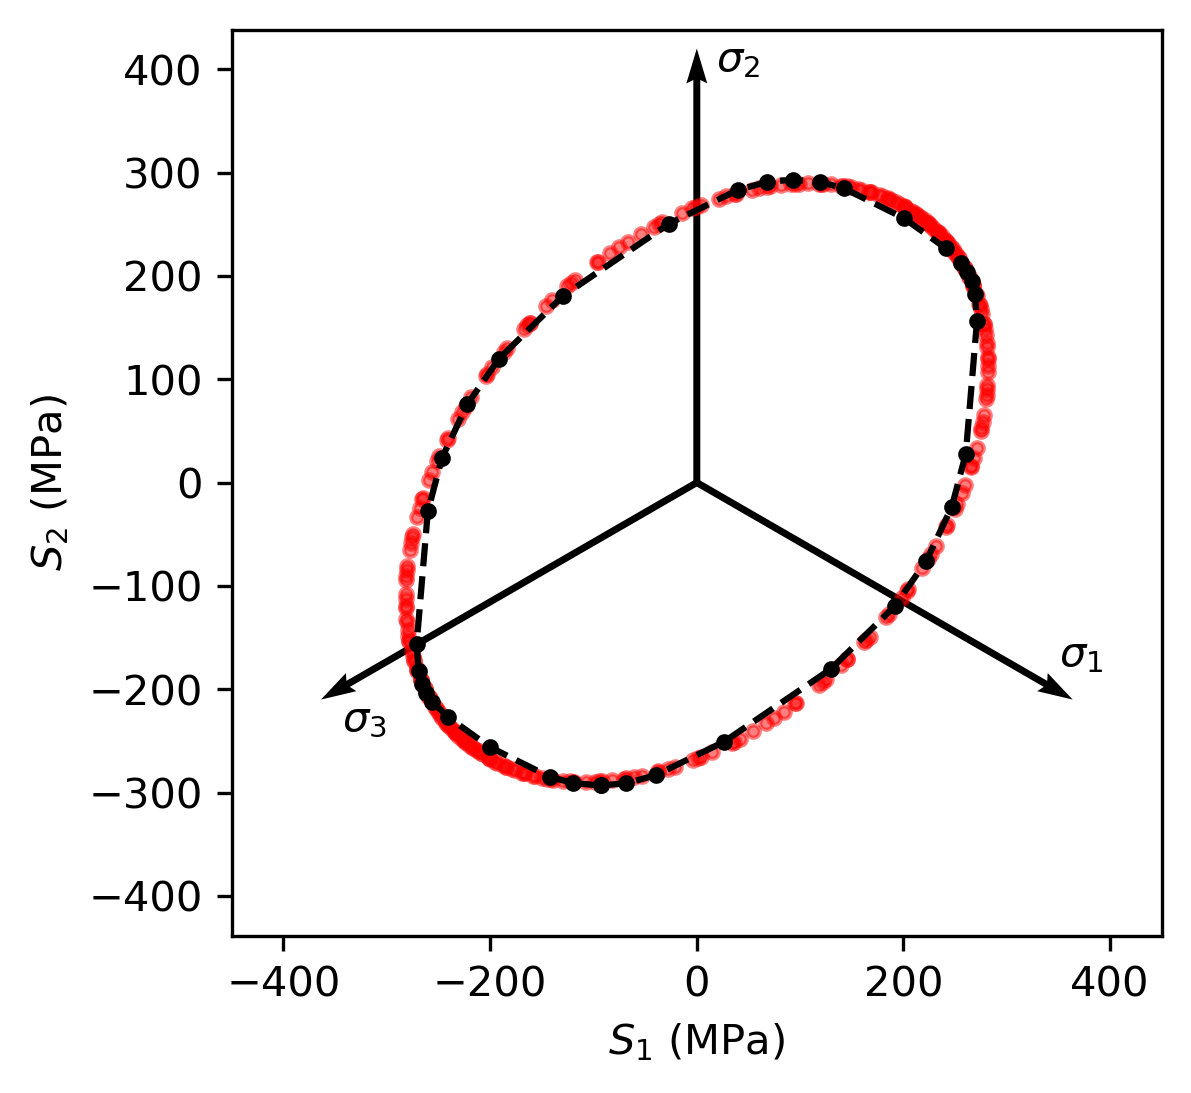

In [75]:


ax = plot_trajectory_of_transpose_pi('/Users/brian/Work/software/st-bingo/research/data/processed_data/vpsc_75_transpose_bingo_format.txt', 1)
ax.scatter(pi_plane_points[1][:,0], pi_plane_points[1][:,1], marker='.', alpha=0.5, c='red')

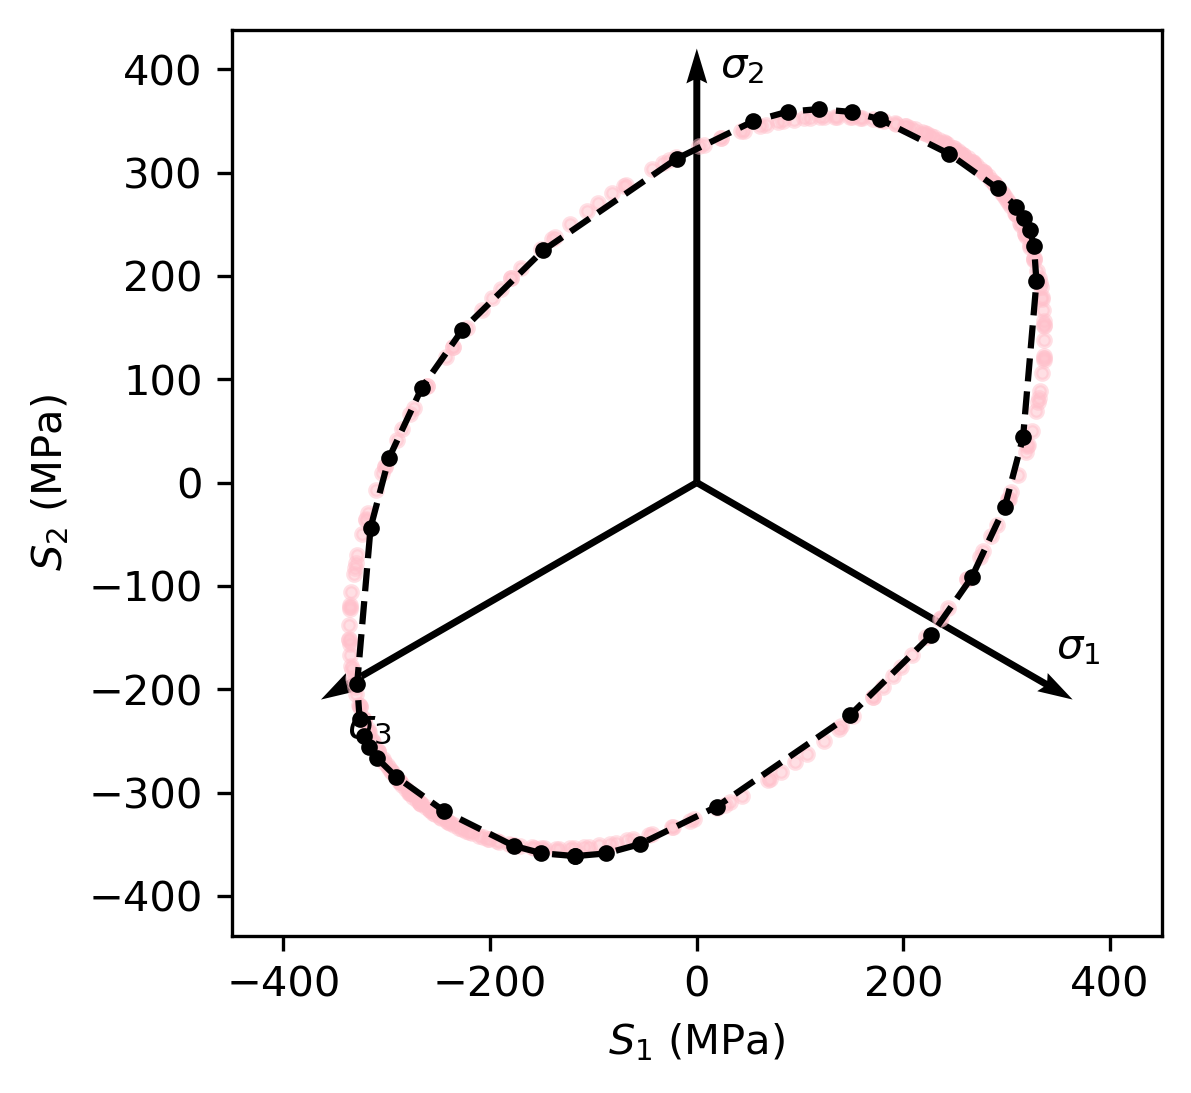

In [76]:

val = 2
ax = plot_trajectory_of_transpose_pi('/Users/brian/Work/software/st-bingo/research/data/processed_data/vpsc_75_transpose_bingo_format.txt', val)
ax.scatter(pi_plane_points[val][:,0], pi_plane_points[val][:,1], marker='.', alpha=0.5, color='pink')

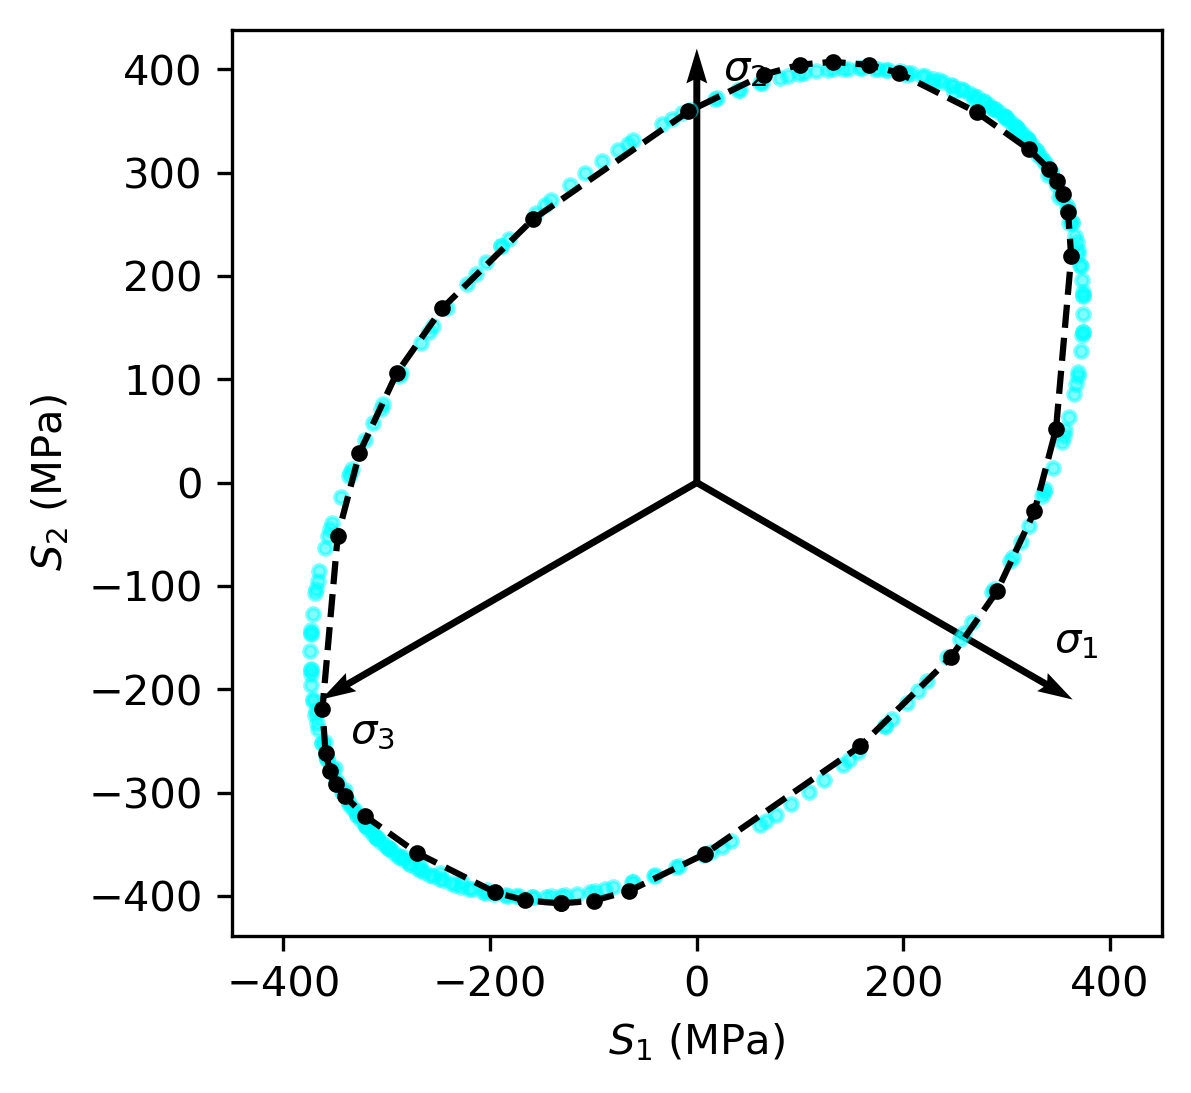

In [77]:
val = 3
ax = plot_trajectory_of_transpose_pi('/Users/brian/Work/software/st-bingo/research/data/processed_data/vpsc_75_transpose_bingo_format.txt', val)
ax.scatter(pi_plane_points[val][:,0], pi_plane_points[val][:,1], marker='.', alpha=0.5, color='cyan')